In [1]:
import scipy.io.wavfile as wav
import scipy.signal as sig

import matplotlib.pyplot as plt
import numpy as np

import IPython.display as ipd

import numpy as np
from numpy.linalg import norm

from scipy.signal import lfilter, lfiltic
from tqdm import tqdm, tqdm_notebook as tn

from spectrum import arburg
from spectrum.burg import _arburg2

In [2]:
def LPC(previous_sig, next_sig, gap_start, gap_end, lpc_order):

    target_length = gap_end - gap_start
    
    ab, _, _ = _arburg2(previous_sig, lpc_order)
    Zb = lfiltic(b=[1], a=ab, y=previous_sig[:-lpc_order-1:-1])
    forw_pred, _ = lfilter(b=[1], a=ab, x=np.zeros((target_length)), zi=Zb)

    next_sig = np.flipud(next_sig)
    af, _, _ = _arburg2(next_sig, lpc_order)
    Zf = lfiltic([1], af, next_sig[:-lpc_order-1:-1])
    backw_pred, _ = lfilter([1], af, np.zeros((target_length)), zi=Zf)
    backw_pred = np.flipud(backw_pred)

    t = np.linspace(0, np.pi/2, target_length)
    sqCos = np.cos(t)**2
    sigout = sqCos*forw_pred + np.flipud(sqCos)*backw_pred
    return sigout

In [3]:
SNR = lambda y, y_hat: 20 * (np.log10(norm(y)) - np.log10(norm(y-y_hat)))

In [4]:
def plot_signal_by_parts(signal, gap_start, gap_end, gap=None):
    if gap is None:
        plt.title("Original signal")
        plt.plot(np.arange(gap_start), signal[:gap_start])
        plt.plot(np.arange(gap_start, gap_end), signal[gap_start:gap_end])
        plt.plot(np.arange(gap_end, len(signal)), signal[gap_end:])
    else:
        plt.title("Reconstructed signal")
        plt.plot(np.arange(gap_start), signal[:gap_start])
        plt.plot(np.arange(gap_start, gap_end), gap)
        plt.plot(np.arange(gap_end, len(signal)), signal[gap_end:])
    
    plt.show()

# TESTING WITH RML

In [5]:
from multiprocessing import Pool
from multiprocessing.pool import ThreadPool
import multiprocessing
import pickle
import torch

from mlp import audio
from mlp import normalization
from mlp import utils as mlp
from mlp.dataset import WAVAudioDS, TimePostprocessing, WAVTimeAudioDS, PolarPreprocessing, torch_out_to_time_domain

In [6]:
fs = 48000
bs = 1
stroke_width_ms = 32
patch_width = 64
patch_height = 64

In [7]:
preprocess = PolarPreprocessing(
    normalization.norm_mag, 
    normalization.norm_phase, 
    patch_width, 
    patch_height
)


# stroke_mask = mlp.build_stroke_purge_mask(patch_width, patch_height, stroke_width_ms, fs, nperseg=256)
time_mask = mlp.build_time_purge_mask(patch_width, stroke_width_ms, fs)

val_files = pickle.load(open("../files/valid.pk", "rb"))[:20]

torch.multiprocessing.set_sharing_strategy('file_system') # I was getting memory errors without this line.
with Pool(8) as p:
    ds_valid = WAVTimeAudioDS(files=val_files, mk_source=lambda x: x * time_mask, preprocess=preprocess, 
                          patch_width=patch_width, proc_pool=p, fs=fs, random_patches=False) 

100%|██████████| 20/20 [00:00<00:00, 7531.52it/s]


In [8]:
len(ds_valid)

371

In [9]:
lpc_order = 600
rec_signals = []
snr_list = []

for i, (src, target) in tqdm(enumerate(ds_valid), total=len(ds_valid)):
    
    sample_length = len(target)
    sample_ms = int(np.floor(32 * fs / 1000))
    gap_start = sample_length // 2 - sample_ms // 2
    gap_end = gap_start + sample_ms
    
    context_size = 3000

    previous_sig = target[gap_start-context_size:gap_start]
    gap_sig = target[gap_start:gap_end]
    next_sig = target[gap_end:gap_end+context_size]

    if len(previous_sig) == 0 or len(next_sig) == 0:
        continue
        
    lpc_signal = LPC(previous_sig, next_sig, gap_start, gap_end, lpc_order)
    # plot_signal_by_parts(target, gap_start, gap_end, lpc_signal)
    snr_value = SNR(target[gap_start:gap_end], lpc_signal)
    
    rec_signals.append(lpc_signal)
    snr_list.append(snr_value)
        
    if i == 10000:
        break

  0%|          | 0/371 [00:00<?, ?it/s]/home/hector/miniconda3/envs/generative-audio-inpainting/lib/python3.6/site-packages/spectrum/burg.py:77: ComplexWarning: Casting complex values to real discards the imaginary part
  E[m+1] = (1 - ref[m].conj().transpose()*ref[m]) * E[m]
/home/hector/miniconda3/envs/generative-audio-inpainting/lib/python3.6/site-packages/scipy/signal/signaltools.py:1465: ComplexWarning: Casting complex values to real discards the imaginary part
  zi[m] -= np.sum(a[m + 1:] * y[:N - m], axis=0)
100%|██████████| 371/371 [00:30<00:00, 12.14it/s]


In [10]:
import mlp.complx as complx

def get_norm_mag_from_freqs(freqs):
    freqs[0], freqs[1] = complx.to_polar(freqs)
    freqs[0], freqs[1] = normalization.norm_mag(freqs[0]), normalization.norm_phase(freqs[1])
    return freqs[0]

def reconstruct_with_target_phase(lpc_signal, target):
    _, _, target = audio.stft(target, fs=fs, nperseg=256)
    target = target[:,:-2]
    target = WAVAudioDS.freqs_to_torch(target, max_freqs=64)  
    target[0], target[1] = complx.to_polar(target)
    target[0], target[1] = normalization.norm_mag(target[0]), normalization.norm_phase(target[1])

    _, _, lpc_signal = audio.stft(lpc_signal, fs=fs, nperseg=256)
    lpc_signal = lpc_signal[:,:-2]
    lpc_signal = WAVAudioDS.freqs_to_torch(lpc_signal, max_freqs=64)
    lpc_signal[0], lpc_signal[1] = complx.to_polar(lpc_signal)
    lpc_signal[0], lpc_signal[1] = normalization.norm_mag(lpc_signal[0]), normalization.norm_phase(lpc_signal[1])
    
    rec_signal = torch.stack([lpc_signal[0], target[1]])
    rec_signal = torch_out_to_time_domain([rec_signal])[0]
    target_signal = torch_out_to_time_domain([target])[0]
    
    return rec_signal, lpc_signal[0], target_signal, target[0]


mse = lambda y, y_hat: ((y - y_hat)**2).mean()

0it [00:00, ?it/s]

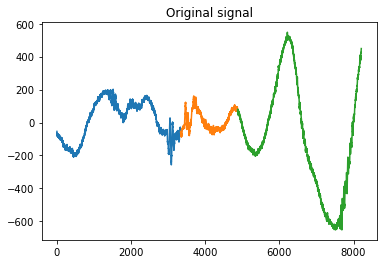

/home/hector/.local/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


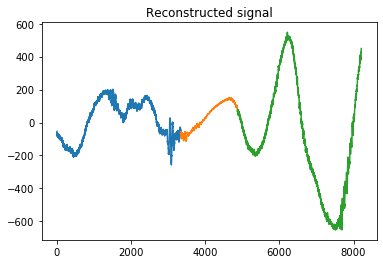

/home/hector/miniconda3/envs/generative-audio-inpainting/lib/python3.6/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part

100%|██████████| 1/1 [00:00<00:00, 2910.69it/s]

100%|██████████| 1/1 [00:00<00:00, 804.28it/s]

100%|██████████| 1/1 [00:00<00:00, 5461.33it/s]

100%|██████████| 1/1 [00:00<00:00, 1331.95it/s]
1it [00:00,  3.30it/s]
100%|██████████| 1/1 [00:00<00:00, 4578.93it/s]

100%|██████████| 1/1 [00:00<00:00, 724.66it/s]

100%|██████████| 1/1 [00:00<00:00, 4202.71it/s]

100%|██████████| 1/1 [00:00<00:00, 564.13it/s]

100%|██████████| 1/1 [00:00<00:00, 6853.44it/s]

100%|██████████| 1/1 [00:00<00:00, 1212.93it/s]

100%|██████████| 1/1 [00:00<00:00, 2962.08it/s]

100%|██████████| 1/1 [00:00<00:00, 1013.61it/s]

100%|██████████| 1/1 [00:00<00:00, 4514.86it/s]

100%|██████████| 1/1 [00:00<00:00, 833.36it/s]

100%|██████████| 1/1 [00:00<00:00, 6472.69it/s]

100%|██████████| 1/1 [00:00<00:00, 567.72it/s]

100%|███████

100%|██████████| 1/1 [00:00<00:00, 508.65it/s]

100%|██████████| 1/1 [00:00<00:00, 1356.50it/s]

100%|██████████| 1/1 [00:00<00:00, 445.54it/s]

100%|██████████| 1/1 [00:00<00:00, 1566.79it/s]

100%|██████████| 1/1 [00:00<00:00, 417.72it/s]

100%|██████████| 1/1 [00:00<00:00, 1587.55it/s]

100%|██████████| 1/1 [00:00<00:00, 230.62it/s]

100%|██████████| 1/1 [00:00<00:00, 6297.75it/s]

100%|██████████| 1/1 [00:00<00:00, 630.06it/s]

100%|██████████| 1/1 [00:00<00:00, 4529.49it/s]

100%|██████████| 1/1 [00:00<00:00, 721.41it/s]
43it [00:01, 26.94it/s]
100%|██████████| 1/1 [00:00<00:00, 6754.11it/s]

100%|██████████| 1/1 [00:00<00:00, 817.13it/s]

100%|██████████| 1/1 [00:00<00:00, 2055.02it/s]

100%|██████████| 1/1 [00:00<00:00, 331.36it/s]

100%|██████████| 1/1 [00:00<00:00, 1570.90it/s]

100%|██████████| 1/1 [00:00<00:00, 320.86it/s]

100%|██████████| 1/1 [00:00<00:00, 3113.81it/s]

100%|██████████| 1/1 [00:00<00:00, 1289.76it/s]

100%|██████████| 1/1 [00:00<00:00, 5957.82it/s]

100%|█

100%|██████████| 1/1 [00:00<00:00, 2050.00it/s]

100%|██████████| 1/1 [00:00<00:00, 346.89it/s]

100%|██████████| 1/1 [00:00<00:00, 2555.94it/s]

100%|██████████| 1/1 [00:00<00:00, 353.65it/s]

100%|██████████| 1/1 [00:00<00:00, 1626.33it/s]

100%|██████████| 1/1 [00:00<00:00, 246.75it/s]

100%|██████████| 1/1 [00:00<00:00, 6721.64it/s]

100%|██████████| 1/1 [00:00<00:00, 923.45it/s]

100%|██████████| 1/1 [00:00<00:00, 1754.20it/s]

100%|██████████| 1/1 [00:00<00:00, 584.57it/s]

100%|██████████| 1/1 [00:00<00:00, 6105.25it/s]

100%|██████████| 1/1 [00:00<00:00, 814.59it/s]

100%|██████████| 1/1 [00:00<00:00, 4604.07it/s]

100%|██████████| 1/1 [00:00<00:00, 779.03it/s]
85it [00:02, 42.89it/s]
100%|██████████| 1/1 [00:00<00:00, 2845.53it/s]

100%|██████████| 1/1 [00:00<00:00, 1043.36it/s]

100%|██████████| 1/1 [00:00<00:00, 1787.85it/s]

100%|██████████| 1/1 [00:00<00:00, 1255.78it/s]

100%|██████████| 1/1 [00:00<00:00, 3994.58it/s]

100%|██████████| 1/1 [00:00<00:00, 596.97it/s]

100%|

100%|██████████| 1/1 [00:00<00:00, 1182.49it/s]

100%|██████████| 1/1 [00:00<00:00, 3672.77it/s]

100%|██████████| 1/1 [00:00<00:00, 803.66it/s]

100%|██████████| 1/1 [00:00<00:00, 6921.29it/s]

100%|██████████| 1/1 [00:00<00:00, 1338.75it/s]

100%|██████████| 1/1 [00:00<00:00, 3833.92it/s]

100%|██████████| 1/1 [00:00<00:00, 643.69it/s]

100%|██████████| 1/1 [00:00<00:00, 3506.94it/s]

100%|██████████| 1/1 [00:00<00:00, 560.81it/s]
125it [00:02, 48.57it/s]
100%|██████████| 1/1 [00:00<00:00, 5133.79it/s]

100%|██████████| 1/1 [00:00<00:00, 555.91it/s]

100%|██████████| 1/1 [00:00<00:00, 2099.25it/s]

100%|██████████| 1/1 [00:00<00:00, 270.51it/s]

100%|██████████| 1/1 [00:00<00:00, 4718.00it/s]

100%|██████████| 1/1 [00:00<00:00, 998.88it/s]

100%|██████████| 1/1 [00:00<00:00, 2259.86it/s]

100%|██████████| 1/1 [00:00<00:00, 318.55it/s]

100%|██████████| 1/1 [00:00<00:00, 1001.03it/s]

100%|██████████| 1/1 [00:00<00:00, 561.49it/s]

100%|██████████| 1/1 [00:00<00:00, 640.16it/s]

100%|

100%|██████████| 1/1 [00:00<00:00, 579.40it/s]

100%|██████████| 1/1 [00:00<00:00, 5005.14it/s]

100%|██████████| 1/1 [00:00<00:00, 720.05it/s]

100%|██████████| 1/1 [00:00<00:00, 4707.41it/s]

100%|██████████| 1/1 [00:00<00:00, 442.34it/s]
165it [00:03, 46.89it/s]
100%|██████████| 1/1 [00:00<00:00, 5489.93it/s]

100%|██████████| 1/1 [00:00<00:00, 402.79it/s]

100%|██████████| 1/1 [00:00<00:00, 2259.86it/s]

100%|██████████| 1/1 [00:00<00:00, 611.06it/s]

100%|██████████| 1/1 [00:00<00:00, 6605.20it/s]

100%|██████████| 1/1 [00:00<00:00, 1181.16it/s]

100%|██████████| 1/1 [00:00<00:00, 3050.40it/s]

100%|██████████| 1/1 [00:00<00:00, 758.88it/s]

100%|██████████| 1/1 [00:00<00:00, 4644.85it/s]

100%|██████████| 1/1 [00:00<00:00, 280.27it/s]

100%|██████████| 1/1 [00:00<00:00, 2005.88it/s]

100%|██████████| 1/1 [00:00<00:00, 596.12it/s]

100%|██████████| 1/1 [00:00<00:00, 3116.12it/s]

100%|██████████| 1/1 [00:00<00:00, 1054.91it/s]

100%|██████████| 1/1 [00:00<00:00, 3956.89it/s]

100%

100%|██████████| 1/1 [00:00<00:00, 1059.70it/s]

100%|██████████| 1/1 [00:00<00:00, 5146.39it/s]

100%|██████████| 1/1 [00:00<00:00, 486.52it/s]

100%|██████████| 1/1 [00:00<00:00, 3949.44it/s]

100%|██████████| 1/1 [00:00<00:00, 604.54it/s]

100%|██████████| 1/1 [00:00<00:00, 4315.13it/s]

100%|██████████| 1/1 [00:00<00:00, 605.33it/s]

100%|██████████| 1/1 [00:00<00:00, 1784.81it/s]

100%|██████████| 1/1 [00:00<00:00, 450.47it/s]
207it [00:04, 46.63it/s]
100%|██████████| 1/1 [00:00<00:00, 2041.02it/s]

100%|██████████| 1/1 [00:00<00:00, 621.47it/s]

100%|██████████| 1/1 [00:00<00:00, 2571.61it/s]

100%|██████████| 1/1 [00:00<00:00, 941.48it/s]

100%|██████████| 1/1 [00:00<00:00, 4815.50it/s]

100%|██████████| 1/1 [00:00<00:00, 480.89it/s]

100%|██████████| 1/1 [00:00<00:00, 3650.40it/s]

100%|██████████| 1/1 [00:00<00:00, 695.34it/s]

100%|██████████| 1/1 [00:00<00:00, 3830.41it/s]

100%|██████████| 1/1 [00:00<00:00, 551.23it/s]

100%|██████████| 1/1 [00:00<00:00, 2951.66it/s]

100%|

100%|██████████| 1/1 [00:00<00:00, 3833.92it/s]

100%|██████████| 1/1 [00:00<00:00, 637.14it/s]

100%|██████████| 1/1 [00:00<00:00, 4009.85it/s]

100%|██████████| 1/1 [00:00<00:00, 635.21it/s]
247it [00:05, 49.17it/s]
100%|██████████| 1/1 [00:00<00:00, 4894.17it/s]

100%|██████████| 1/1 [00:00<00:00, 1162.82it/s]

100%|██████████| 1/1 [00:00<00:00, 1010.43it/s]

100%|██████████| 1/1 [00:00<00:00, 585.47it/s]

100%|██████████| 1/1 [00:00<00:00, 3833.92it/s]

100%|██████████| 1/1 [00:00<00:00, 527.39it/s]

100%|██████████| 1/1 [00:00<00:00, 5454.23it/s]

100%|██████████| 1/1 [00:00<00:00, 392.21it/s]

100%|██████████| 1/1 [00:00<00:00, 3637.73it/s]

100%|██████████| 1/1 [00:00<00:00, 563.45it/s]

100%|██████████| 1/1 [00:00<00:00, 6345.39it/s]

100%|██████████| 1/1 [00:00<00:00, 865.70it/s]

100%|██████████| 1/1 [00:00<00:00, 6384.02it/s]

100%|██████████| 1/1 [00:00<00:00, 671.41it/s]

100%|██████████| 1/1 [00:00<00:00, 2473.06it/s]

100%|██████████| 1/1 [00:00<00:00, 441.51it/s]

100%|

100%|██████████| 1/1 [00:00<00:00, 3682.44it/s]

100%|██████████| 1/1 [00:00<00:00, 831.71it/s]

100%|██████████| 1/1 [00:00<00:00, 4899.89it/s]

100%|██████████| 1/1 [00:00<00:00, 693.85it/s]

100%|██████████| 1/1 [00:00<00:00, 2673.23it/s]

100%|██████████| 1/1 [00:00<00:00, 780.05it/s]

100%|██████████| 1/1 [00:00<00:00, 1855.07it/s]

100%|██████████| 1/1 [00:00<00:00, 1231.08it/s]
289it [00:06, 45.24it/s]
100%|██████████| 1/1 [00:00<00:00, 4410.41it/s]

100%|██████████| 1/1 [00:00<00:00, 682.44it/s]

100%|██████████| 1/1 [00:00<00:00, 3930.93it/s]

100%|██████████| 1/1 [00:00<00:00, 375.23it/s]

100%|██████████| 1/1 [00:00<00:00, 7269.16it/s]

100%|██████████| 1/1 [00:00<00:00, 857.38it/s]

100%|██████████| 1/1 [00:00<00:00, 2280.75it/s]

100%|██████████| 1/1 [00:00<00:00, 892.03it/s]

100%|██████████| 1/1 [00:00<00:00, 2206.37it/s]

100%|██████████| 1/1 [00:00<00:00, 913.39it/s]

100%|██████████| 1/1 [00:00<00:00, 2759.41it/s]

100%|██████████| 1/1 [00:00<00:00, 612.22it/s]

100%|

100%|██████████| 1/1 [00:00<00:00, 3339.41it/s]

100%|██████████| 1/1 [00:00<00:00, 397.68it/s]

100%|██████████| 1/1 [00:00<00:00, 5777.28it/s]

100%|██████████| 1/1 [00:00<00:00, 817.44it/s]

100%|██████████| 1/1 [00:00<00:00, 1367.11it/s]

100%|██████████| 1/1 [00:00<00:00, 546.20it/s]

100%|██████████| 1/1 [00:00<00:00, 2577.94it/s]

100%|██████████| 1/1 [00:00<00:00, 624.34it/s]

100%|██████████| 1/1 [00:00<00:00, 6492.73it/s]

100%|██████████| 1/1 [00:00<00:00, 869.47it/s]

100%|██████████| 1/1 [00:00<00:00, 2289.47it/s]

100%|██████████| 1/1 [00:00<00:00, 528.85it/s]
331it [00:07, 44.20it/s]
100%|██████████| 1/1 [00:00<00:00, 2520.62it/s]

100%|██████████| 1/1 [00:00<00:00, 769.17it/s]

100%|██████████| 1/1 [00:00<00:00, 960.01it/s]

100%|██████████| 1/1 [00:00<00:00, 708.62it/s]

100%|██████████| 1/1 [00:00<00:00, 4350.94it/s]

100%|██████████| 1/1 [00:00<00:00, 651.80it/s]

100%|██████████| 1/1 [00:00<00:00, 799.68it/s]

100%|██████████| 1/1 [00:00<00:00, 429.04it/s]

100%|███

100%|██████████| 1/1 [00:00<00:00, 4324.02it/s]

100%|██████████| 1/1 [00:00<00:00, 782.67it/s]

100%|██████████| 1/1 [00:00<00:00, 1494.76it/s]

100%|██████████| 1/1 [00:00<00:00, 851.12it/s]

100%|██████████| 1/1 [00:00<00:00, 7182.03it/s]

100%|██████████| 1/1 [00:00<00:00, 651.90it/s]

100%|██████████| 1/1 [00:00<00:00, 5077.85it/s]

100%|██████████| 1/1 [00:00<00:00, 1251.66it/s]
371it [00:08, 46.09it/s]


In [11]:
mse_list = []
snr_list = []
snr_list_or_phase = []

for i, (lpc_signal, (src, target)) in tqdm(enumerate(zip(rec_signals, ds_valid))):

    if lpc_signal is None:
        continue
        
    sample_length = len(target)
    sample_ms = int(np.floor(32 * fs / 1000))
    gap_start = sample_length // 2 - sample_ms // 2
    gap_end = gap_start + sample_ms
    
    if i == 0:
        plot_signal_by_parts(target, gap_start, gap_end)
        plot_signal_by_parts(target, gap_start, gap_end, lpc_signal)

    snr_list.append(SNR(target[gap_start:gap_end], lpc_signal))
    
    lpc_signal = np.concatenate([target[:gap_start], lpc_signal, target[gap_end:]]).astype(np.float32)    
    rec_signal_time, rec_signal_mag, target_time, target_mag = reconstruct_with_target_phase(lpc_signal, target)
    
    snr_list_or_phase.append(SNR(target_time[gap_start:gap_end], rec_signal_time[gap_start:gap_end]))
    mse_list.append(mse(target_mag[:, 26:38], rec_signal_mag[:, 26:38]))

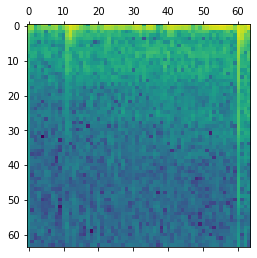

In [12]:
plt.matshow(target_mag)

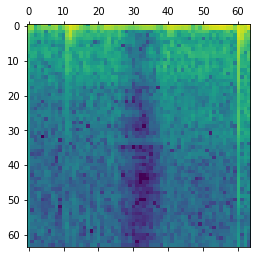

In [13]:
plt.matshow(rec_signal_mag, vmin=np.min(target_mag.numpy()), vmax=np.max(target_mag.numpy()))

In [14]:
mse(target_mag[:, 26:38], rec_signal_mag[:, 26:38])

tensor(0.6327)

# Mean SNR and MSE

LPC
SNR: 1.9089191838948438
SNR std: 3.774737570598467


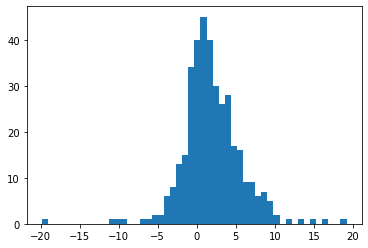

In [15]:
print('LPC')
print('SNR:', np.mean(snr_list))
print('SNR std:', np.std(snr_list))
counts, bins, _ = plt.hist(snr_list, bins=50)

LPC
SNR: 10.92253442664978
SNR std: 0.5911278827736582


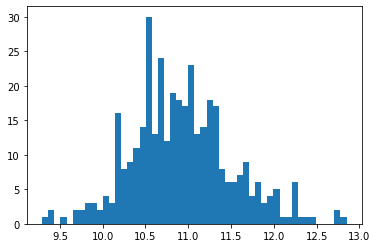

In [16]:
print('LPC')
print('SNR:', np.mean(snr_list_or_phase))
print('SNR std:', np.std(snr_list_or_phase))
counts, bins, _ = plt.hist(snr_list_or_phase, bins=50)

LPC
MSE: 0.5417042
MSE std: 0.3149831


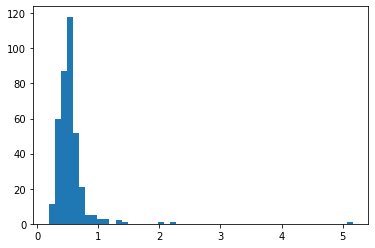

In [17]:
print('LPC')
print('MSE:', np.mean(mse_list))
print('MSE std:', np.std(mse_list))
_ = plt.hist(mse_list, bins=50)